# Gene Expression Level Analysis Using nanoString Data

In this Jupyter notebook, we are providing the code for the analysis of nanoString data, and we are integrating this data with survival information, our digital marker scores, and immunohistochemistry (IHC) manual annotations for five markers, creating a comprehensive framework for our investigation. By amalgamating these diverse datasets, we aim to uncover intricate relationships between gene expression patterns, survival outcomes, and the presence of specific markers.


## Methods


> **See Also**: For a more in-depth tour about statistical methods you can visit the following papers:
- z-Score: Cheadle C, Vawter MP, Freed WJ, Becker KG. Analysis of Microarray Data Using Z Score Transformation. J Mol Diagn. 2003 May;5(2):73–81
- PCA: Raychaudhuri S, Stuart JM, Altman RB. PRINCIPAL COMPONENTS ANALYSIS TO SUMMARIZE MICROARRAY EXPERIMENTS: APPLICATION TO SPORULATION TIME SERIES. Pac Symp Biocomput. 2000;455–66.
- Spearman correlation: Guo Y, Sheng Q, Li J, Ye F, Samuels DC, Shyr Y. Large Scale Comparison of Gene Expression Levels by Microarrays and RNAseq Using TCGA Data. PLOS ONE. 2013 Aug 20;8(8):e71462
- Bonferroni correction: Armstrong RA. When to use the Bonferroni correction. Ophthalmic and Physiological Optics. 2014;34(5):502–8
- CoxPh: Lin DY, Wei LJ. The Robust Inference for the Cox Proportional Hazards Model. Journal of the American Statistical Association
- GSEA: Subramanian A, Tamayo P, Mootha VK, Mukherjee S, Ebert BL, Gillette MA, et al. Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles. Proceedings of the National Academy of Sciences. 2005 Oct 25;102(43):15545–50


## Data

- For our analysis we used two techniques to fairly apply our methods due to its limitation:
    - Bootstrap resampling
    - k-fold cross-validation

### **python** libraries:
 -lifelines
 -pandas
 -sklearn

In [3]:
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
import pandas as pd
from scipy.stats import zscore
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

Reading the csv files for all the data that we are going to analyze

In [4]:
#clinical information
clinical_info = pd.read_csv("datasets/clinical.csv")
survival_outcomes = pd.read_csv("datasets/survival_outcomes.csv")

#nanoString related data
nanoString_data = pd.read_csv("datasets/nanoString_gene_expression_levels.csv")
nanoString_genes_descriptions = pd.read_csv("datasets/genes_descriptions.csv")
nanoString_pathways = pd.read_csv("datasets/nanoString_pathways_gene_association_original.csv")
nanoString_PAM50 = pd.read_csv("datasets/PAM50.csv")

#Digital scores related data
digital_scores = pd.read_csv("datasets/digi_scores.csv")

#GSEA related data
GSEA_pathways_all = pd.read_csv("datasets/GSEA_all.csv")
GSEA_pathways_Digi_sTILs = pd.read_csv("datasets/GSEA_Digi_sTILs.csv")
GSEA_pathways_Digi_TAS = pd.read_csv("datasets/GSEA_Digi_TAS.csv")

#TMA scores data
TMA_raw_scores = pd.read_csv("datasets/TMA_raw_scores.csv")
TMA_averaged_scores = pd.read_csv("datasets/TMA_scores_av.csv")
TMA_binary = pd.read_csv("datasets/TMA_binary.csv")

To choose the best number of components for PCA using all genes we will apply some determination methods

In [5]:
def pca_variance(dataset, n_components=0.85):
    pca = PCA(n_components=n_components)
    pca_variance_test = pd.DataFrame(data=pca.fit_transform(dataset))
    PCA_cols = []
    for i in range(0, pca.n_components_):
        PCA_cols.append('PCA_' + str(i + 1))

    pca_variance = pd.DataFrame(data=pca.fit_transform(dataset), columns=PCA_cols)

    return pca_variance

In [6]:
# ------------- Scree Plot---------------
def scree_plot(dataset):
    pca = PCA(n_components=20)

    pca.fit_transform(dataset)
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

To cluster the genes to subgroups

In [7]:
def hierarchical_clustering(data, cluster_number=2):
    # create a linkage matrix
    Z = linkage(data, method='ward', metric='euclidean')
    fig = plt.figure(figsize=(10, 5))
    dn = dendrogram(Z)
    plt.title('Heierarchical Clustering')
    plt.savefig('heierarchical.png')
    plt.show()


def k_mean_clustering(data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

    # Get the cluster assignments for each sample
    labels = kmeans.labels_

    u_labels = np.unique(labels)

    # Plot the clusters in 2D
    plt.scatter(data[:, 0], data[:, 1], c=labels)

    # plotting the results:
    for i in u_labels:
        # filter rows of original data
        filtered_label = data[labels == i]

        # Plotting the results
        plt.scatter(filtered_label[:, 0], filtered_label[:, 1], label=i)

        # plt.scatter(df[labels == i, 0], df[labels == i, 1], label=i)

    plt.title('K-Means Clustering')
    plt.savefig('k_mean.png')
    plt.show()

To merge the data from two dataset based on their IDs

In [8]:
def merge_two_datasets(data_one, data_two, ID='ID'):
    all_list = []
    for index, row in data_one.iterrows():
        list_ = []
        for IHC_index, IHC_row in data_two.iterrows():
            if IHC_row[ID] == row[ID]:
                for column, value in row.items():
                    list_.append(value)
                for column_, value_ in IHC_row.items():
                    if not (column_ == ID):
                        list_.append(value_)
                all_list.append(list_)

    first_dataset_cols = data_one.columns.tolist()
    second_dataset_cols = data_two.columns.tolist()
    second_dataset_cols.remove(ID)
    final_cols = first_dataset_cols
    final_cols.extend(second_dataset_cols)

    final_dataset = pd.DataFrame(all_list, columns=final_cols)

    return final_dataset

To perform survival using CoxPh from lifelines

In [ ]:
def survival_with_k_folds(data, penalizer=0.0, scoring_method='concordance_index', run_num=10, num_folds=10,
                          print_results=False):
    # Create a Cox Proportional-Hazards model
    cph = CoxPHFitter(penalizer=penalizer)

    # Perform k-fold cross-validation
    results = []
    for _ in range(0, run_num):
        results.extend(k_fold_cross_validation(cph, data, 'time', event_col='event'
                                               , scoring_method=scoring_method, k=num_folds))
    # Print results for each fold
    # for i, result in enumerate(results):
    #     print(f"Fold {i + 1} C-index (concordance index): {result:.3f}")

    # Calculate and print the mean and std for C-index across all folds
    mean_c_index = np.mean(results)
    std_c_index = np.std(results)

    if print_results:
        print(f"\nMean C-index across all folds: {mean_c_index:.3f}")
        print(f"\nSTD C-index across all folds: {std_c_index:.3f}")

    return mean_c_index, std_c_index

Pre-processing the nanoString gene expression levels with z-score and PCA

In [10]:
#remove the IDs
nanoString_data_temp = nanoString_data.drop(['ID'], axis=1)
#apply zscore
nanoString_data_zscore_temp = nanoString_data_temp.apply(zscore)


In [11]:
# --------- PCA Variance  -------------
# we could set the variance to be 85%
nanoString_raw_pca_variance = pca_variance(nanoString_data_temp, n_components=0.85)
# --------- PCA Variance with z-score -------------
nanoString_z_score_pca_variance = pca_variance(nanoString_data_zscore_temp, n_components=0.85)


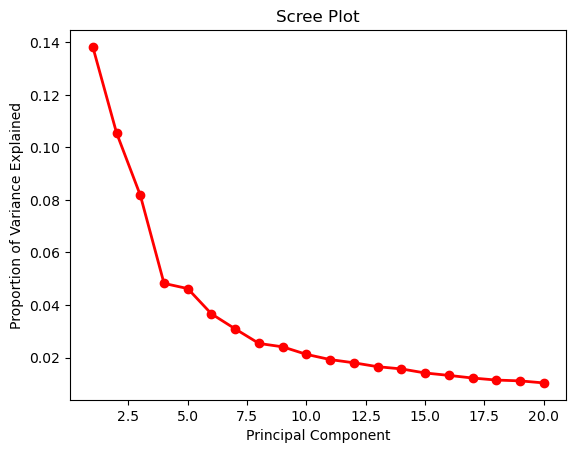

In [12]:
# --------- Scree plot with z_score -------------
pca = PCA(n_components=20)
Principal_components = pca.fit_transform(nanoString_data_temp)

# ------------- Scree Plot---------------
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [13]:
# the scree plot show the best number of PCA components is 5
pca = PCA(n_components=5)
PCA_cols = []
for i in range(0, 5):
    PCA_cols.append('PCA_' + str(i + 1))

nanoString_pca_scree = pd.DataFrame(data=pca.fit_transform(nanoString_data_temp), columns=PCA_cols)
nanoString_z_score_pca_scree = pd.DataFrame(data=pca.fit_transform(nanoString_data_zscore_temp), columns=PCA_cols)


In [14]:
#add IDs back to genes pca, zsocre datasets
nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_data_zscore_temp]
nanoString_data_zscore = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_raw_pca_variance]
nanoString_raw_pca_variance = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_z_score_pca_variance]
nanoString_z_score_pca_variance = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_pca_scree]
nanoString_pca_scree = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_pca_scree.to_csv('nanoString_pca_scree.txt', sep='\t', index=False)

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_z_score_pca_scree]
nanoString_z_score_pca_scree = pd.concat(nanoString_data_IDs, axis=1, join='inner')


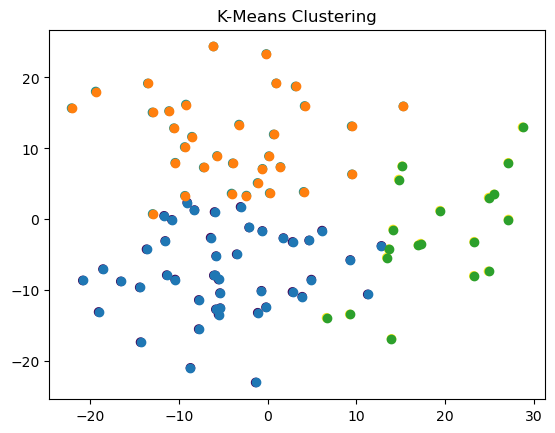

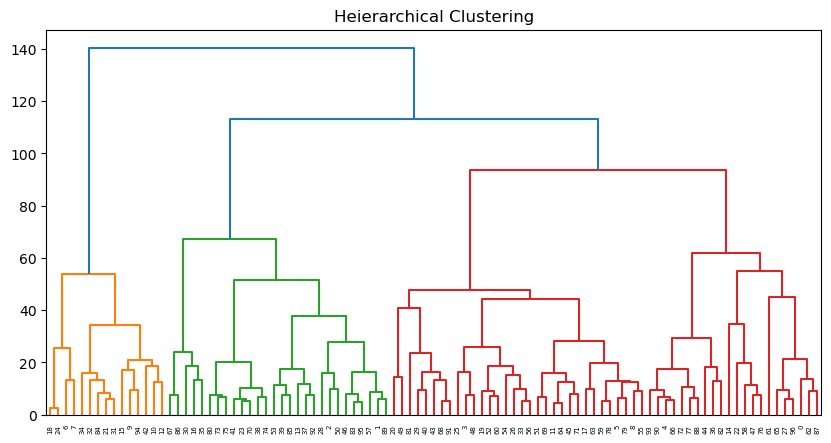

In [15]:
#pefrom clustering on pca scree based dataset
data_temp = nanoString_pca_scree.drop(['ID'], axis=1)
k_mean_clustering(data_temp.to_numpy(), n_clusters=3)
hierarchical_clustering(data_temp, cluster_number=3)



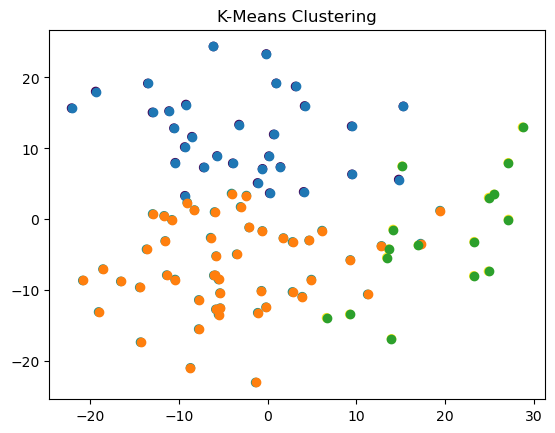

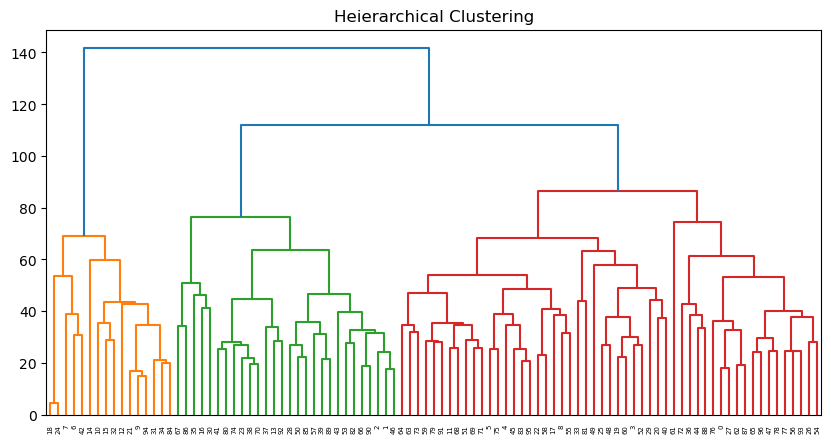

In [16]:
#pefrom clustering on pca variance based dataset
data_temp = nanoString_raw_pca_variance.drop(['ID'], axis=1)
k_mean_clustering(data_temp.to_numpy(), n_clusters=3)
hierarchical_clustering(data_temp, cluster_number=3)

In [17]:
# select the genes that we have their IHC manual scores
columns_nanoString = ['ID', 'AR', 'CLDN3', 'EGFR', 'KRT14', 'KRT5', 'CDH1']
nanoString_data_IHC = nanoString_data[columns_nanoString]

IHC_manual_annotation_nanoString_related_genes = merge_two_datasets(nanoString_data_IHC, TMA_averaged_scores)

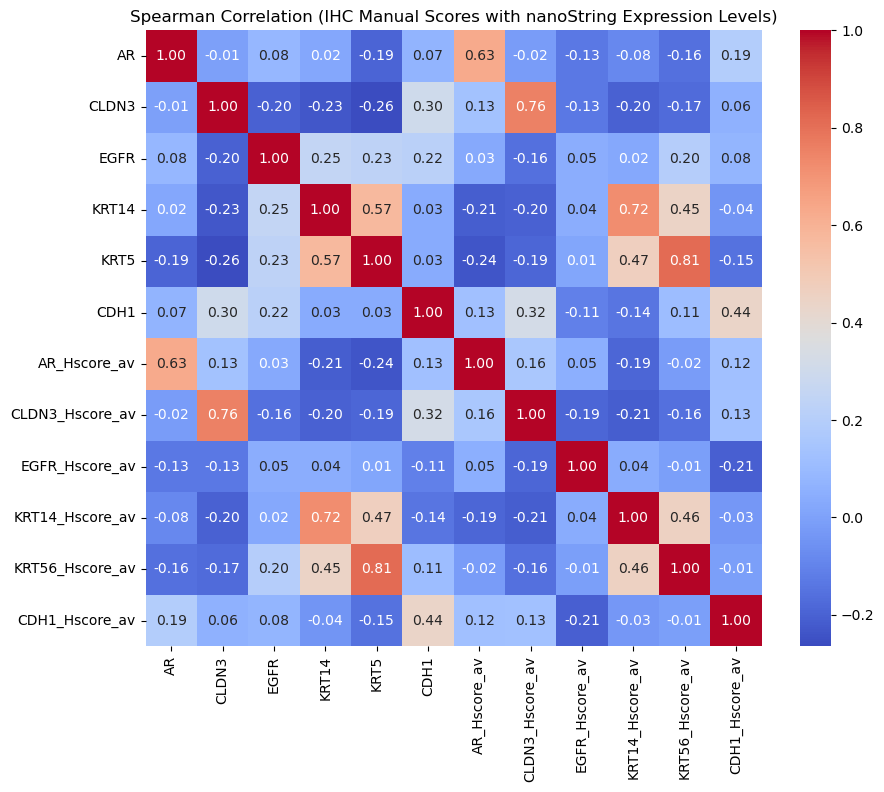

In [18]:
# Calculate Spearman correlation matrix
corr_matrix = IHC_manual_annotation_nanoString_related_genes.corr(method='spearman')

# Create a mask for the upper triangle
#mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap with only the lower triangular part
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)  #, mask=mask)
plt.title('Spearman Correlation (IHC Manual Scores with nanoString Expression Levels)')
plt.savefig('plots/IHC_nanoString_Spearman.png')
plt.show()

In [19]:
# perform the merge with binary classification IHC based for all the IHC genes
IHC_binary_annotation_nanoString_related_genes = merge_two_datasets(nanoString_data_IHC, TMA_binary)
print(
    f"\nThe number of samples with IHC scores and nanoString data: {len(IHC_binary_annotation_nanoString_related_genes):.0f}")


The number of samples with IHC scores and nanoString data: 84


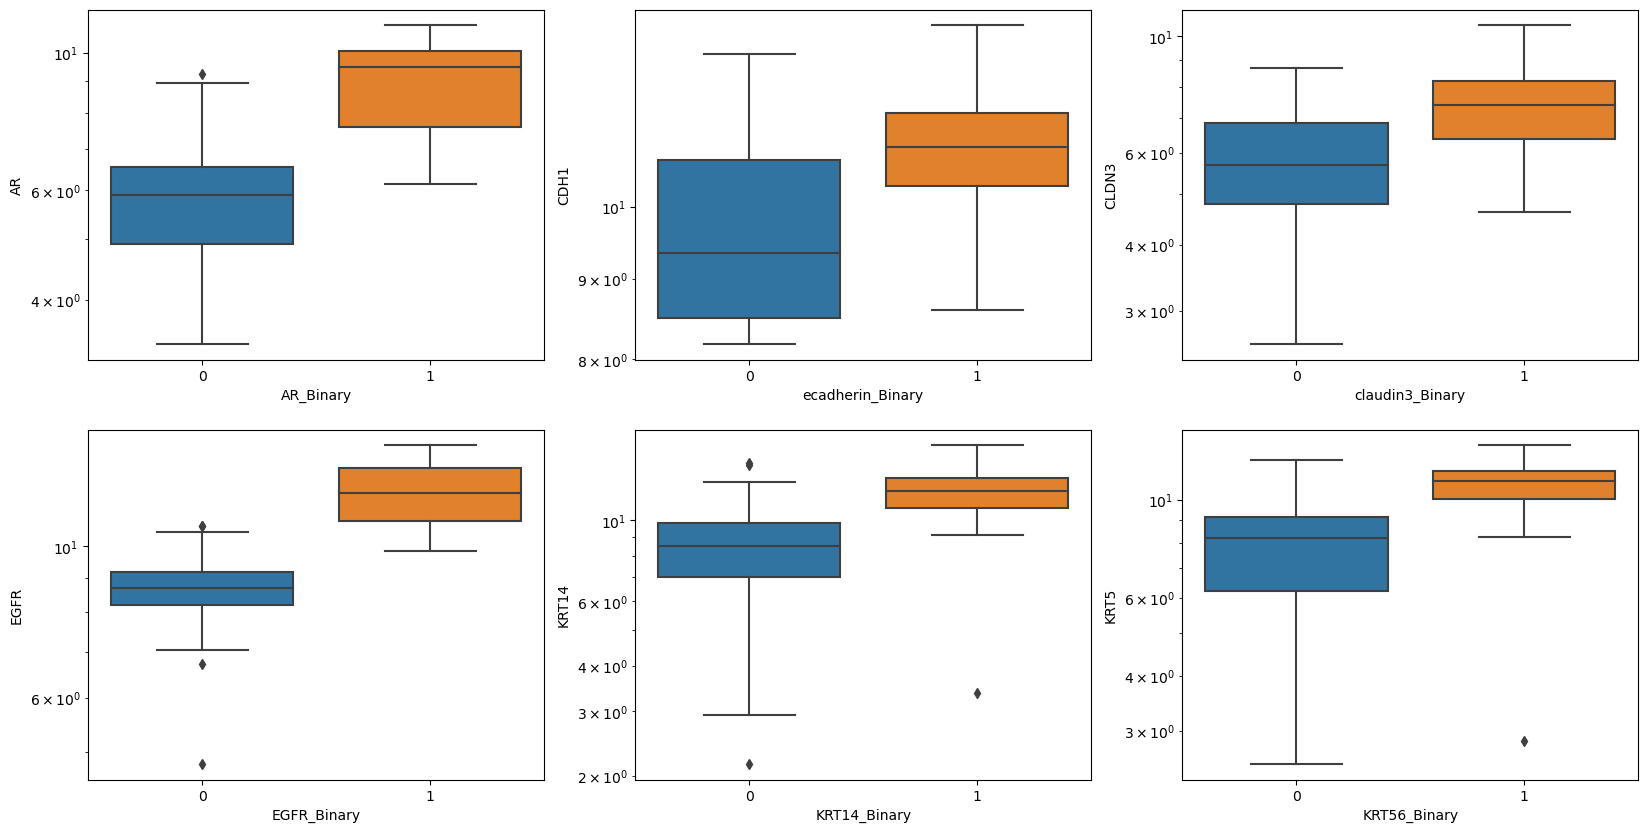

In [20]:
# Create a boxplot of different variables side by side
plt.figure(figsize=(20, 10))
continues_list = ['AR', 'CDH1', 'CLDN3', 'EGFR', 'KRT14', 'KRT5']
binary_list = TMA_binary.columns.tolist()
binary_list.remove('ID')

for i, c in enumerate(continues_list, 1):
    plt.subplot(2, 3, i)
    g = sns.boxplot(x=binary_list[i - 1], y=c, data=IHC_binary_annotation_nanoString_related_genes)
    g.set(yscale="log")
plt.savefig('plots/binary_IHC_nanoString.png')


In [21]:
IHC_PAM50 = merge_two_datasets(nanoString_PAM50, TMA_averaged_scores)
print(
    f"\nThe number of samples with IHC scores and PAM50 data: {len(IHC_PAM50):.0f}")


The number of samples with IHC scores and PAM50 data: 83


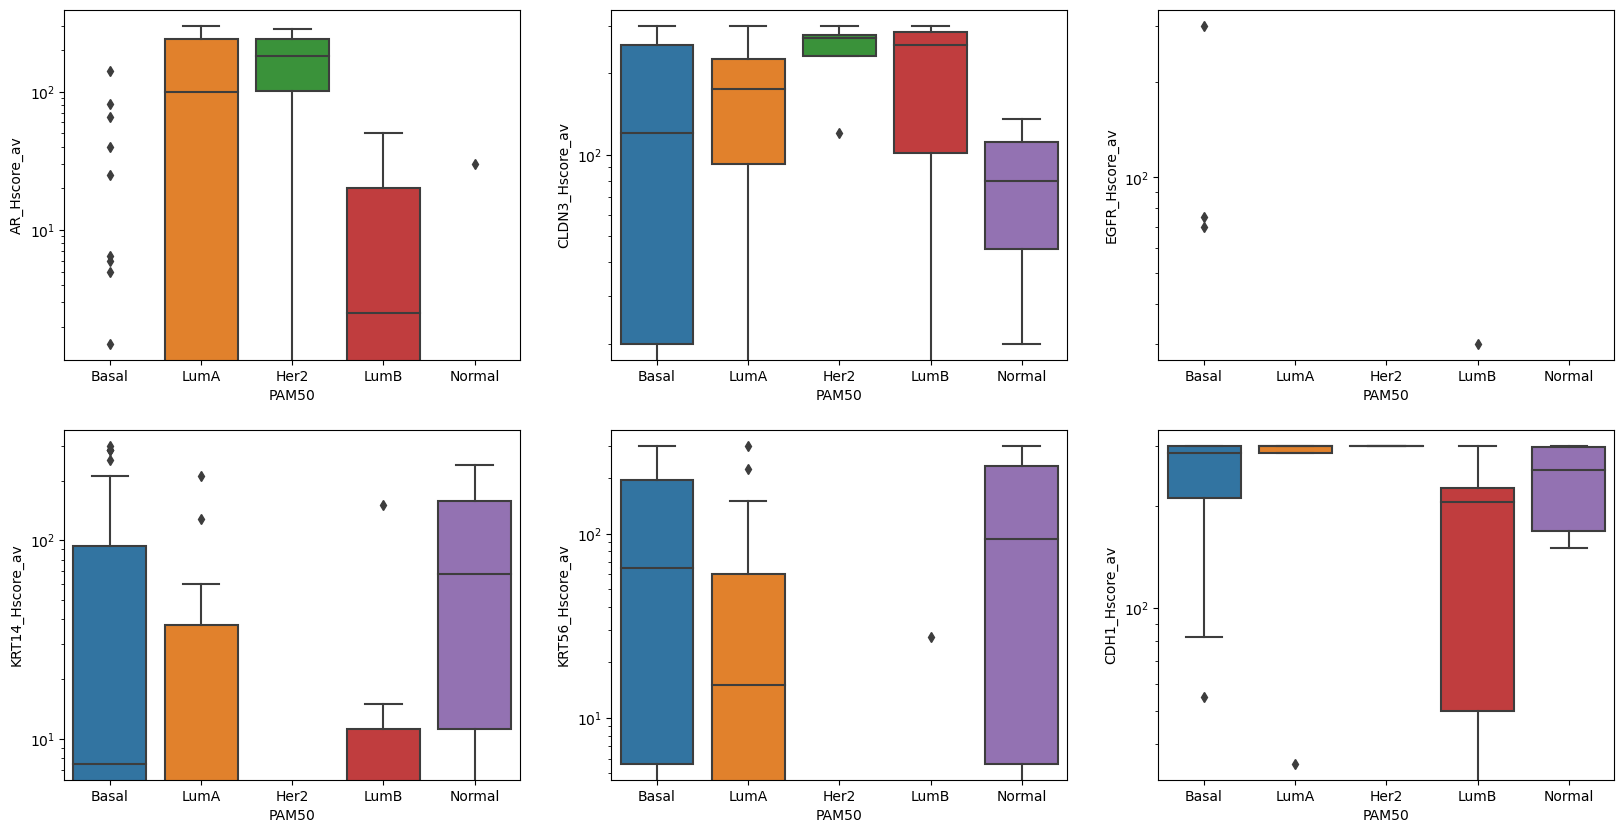

In [22]:
plt.figure(figsize=(20, 10))
continues_list = IHC_PAM50.columns.tolist()

continues_list.remove('PAM50')
continues_list.remove('ID')

for i, c in enumerate(continues_list, 1):
    plt.subplot(2, 3, i)
    g = sns.boxplot(x='PAM50', y=c, data=IHC_PAM50)
    g.set(yscale="log")
#plt.savefig('plots/binary_IHC_nanoString.png')

In [23]:
# perform the merge between PAM50 scores and our digital scores
PAM50_digital_scores = merge_two_datasets(nanoString_PAM50, digital_scores)

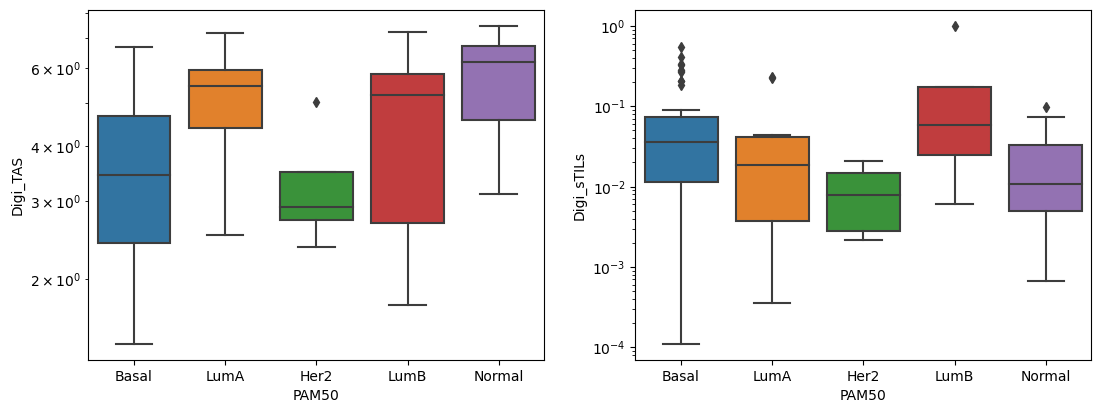

In [24]:
plt.figure(figsize=(20, 10))
column_lists = ['Digi_TAS', 'Digi_sTILs']
for i, c in enumerate(column_lists, 1):
    plt.subplot(2, 3, i)
    g = sns.boxplot(x='PAM50', y=c,
                    data=PAM50_digital_scores)
    g.set(yscale="log")

plt.savefig('plots/pam50_DigiScore.png')



In [25]:
#perfrom the merge between our digital scores and nanoString data
digi_scores_nanoString_gene_expression_levels = merge_two_datasets(nanoString_data, digital_scores)

In [26]:
# List of genes
gene_lists = digi_scores_nanoString_gene_expression_levels.columns.tolist()
gene_lists.remove('ID')
gene_lists.remove('Digi_sTILs')
gene_lists.remove('Digi_TAS')

In [27]:
# apply Spearman correlation with Bonferroni correction

## calculate correlation for Digi-sTILs scores
p_values = []
r_values = []
features = []

digital_scores_column = digi_scores_nanoString_gene_expression_levels['Digi_sTILs']
for gene in gene_lists:
    # Replace this line with actual gene expression data retrieval
    gene_data = digi_scores_nanoString_gene_expression_levels[gene]

    # Calculate Pearson correlation coefficient and p-value
    r, p = spearmanr(gene_data, digital_scores_column)

    # Append results to list_s
    r_values.append(r)
    p_values.append(p)
    features.append(gene)

# Correct p-values using Bonferroni correction
n_tests = len(gene_lists)
corrected_p_values = multipletests(p_values, method='bonferroni')[1]

# Create a pandas DataFrame to display the results as a table
result_df = pd.DataFrame({
    'Gene': features,
    'Spearman Correlation (r)': r_values,
    'Uncorrected p-value': p_values,
    'Bonferroni Corrected p-value': corrected_p_values
})

# Display the table
result_df.to_csv('correlation_nanoString_Digi_sTILs.csv')

In [28]:
## calculate correlation for Digi-TAS scores
p_values = []
r_values = []
features = []

digital_scores_column = digi_scores_nanoString_gene_expression_levels['Digi_TAS']
for gene in gene_lists:
    # Replace this line with actual gene expression data retrieval
    gene_data = digi_scores_nanoString_gene_expression_levels[gene]

    # Calculate Pearson correlation coefficient and p-value
    r, p = spearmanr(gene_data, digital_scores_column)

    # Append results to list_s
    r_values.append(r)
    p_values.append(p)
    features.append(gene)

# Correct p-values using Bonferroni correction
n_tests = len(gene_lists)
corrected_p_values = multipletests(p_values, method='bonferroni')[1]

# Create a pandas DataFrame to display the results as a table
result_df = pd.DataFrame({
    'Gene': features,
    'Spearman Correlation (r)': r_values,
    'Uncorrected p-value': p_values,
    'Bonferroni Corrected p-value': corrected_p_values
})

# Display the table
result_df.to_csv('correlation_nanoString_Digi_TAS.csv')

To perform the survival analysis with different patient data using bootstrapping with overall survival and disease specific survival

In [29]:
# using clinical with DSS, OS and k-folds
dataset = merge_two_datasets(survival_outcomes, clinical_info)

event_col = 'OS'
dataset = dataset.loc[:,
          ['time', event_col, 'age', 'Axillary nodes Flag', 'Sentinel nodes Flag', 'tumour_size']]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

# Look at the categorical and numerical variables
summary_categorical = []
for column in df.columns:
    if df[column].dtype == object:
        summary_categorical.append(column)
        print(df[column].value_counts())
        print(f"----------------------------------")

summary_numerical = []
for column in df.columns:
    if df[column].dtype != object:
        print(f"{column} : Minimum: {min((df[column].unique()))}, Maximum: {max((df[column].unique()))} ")
        summary_numerical.append(column)
        print(f"----------------------------------")

# Convert all string categorical variables into integer labels
encoder = LabelEncoder()
# Convert string categorical variables into integer labels
categorical_columns = df.select_dtypes(include=['object'])
for column in categorical_columns.columns:
    df[column] = encoder.fit_transform(df[column])

print(f"The number of sampels:{len(df)}")

survival_with_k_folds(df, print_results=True)

time : Minimum: 0, Maximum: 273 
----------------------------------
event : Minimum: 0, Maximum: 1 
----------------------------------
age : Minimum: 26, Maximum: 93 
----------------------------------
Axillary nodes Flag : Minimum: 0, Maximum: 1 
----------------------------------
Sentinel nodes Flag : Minimum: 0, Maximum: 1 
----------------------------------
tumour_size : Minimum: 2.0, Maximum: 150.0 
----------------------------------
The number of sampels:358

Mean C-index across all folds: 0.775

STD C-index across all folds: 0.080


(0.774916893454837, 0.0798872385123549)

In [30]:
# using Digi-TAS and Digi-sTILs with DSS, OS and k-folds
dataset = merge_two_datasets(survival_outcomes, digital_scores)

event_col = 'DSS'
dataset = dataset.loc[:,
          ['time', event_col, 'Digi_sTILs', 'Digi_TAS']]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

print(f"The number of sampels:{len(df)}")

survival_with_k_folds(df)

The number of sampels:319


(0.6467991996992605, 0.12668849246388622)

In [31]:
# using IHC markers with DSS, OS, and k-folds
dataset = merge_two_datasets(survival_outcomes, TMA_averaged_scores)
event_col = 'OS'
dataset = dataset.loc[:,
          ['time', event_col, 'AR_Hscore_av', 'CLDN3_Hscore_av', 'KRT14_Hscore_av', 'KRT56_Hscore_av',
           'CDH1_Hscore_av']]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

print(f"The number of sampels:{len(df)}")

survival_with_k_folds(df, print_results=True, num_folds=5)

The number of sampels:219

Mean C-index across all folds: 0.543

STD C-index across all folds: 0.065


(0.5432549420456598, 0.06486957725005162)

In [32]:
dataset = merge_two_datasets(survival_outcomes, nanoString_z_score_pca_scree)

event_col = 'OS'
temp = nanoString_z_score_pca_scree.drop(['ID'], axis=1)
selected_cols = temp.columns.tolist()
selected_cols.extend(['time', event_col])

dataset = dataset.loc[:, selected_cols]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

print(f"The number of samples: {len(df)}")

survival_with_k_folds(df, print_results=True, penalizer=0.0, num_folds=3)

The number of samples: 96

Mean C-index across all folds: 0.552

STD C-index across all folds: 0.099


(0.5523365212858163, 0.09875401692088835)

In [33]:
#All features
dataset_nano = merge_two_datasets(survival_outcomes, nanoString_z_score_pca_scree)

dataset_nano_TMA = merge_two_datasets(dataset_nano, TMA_averaged_scores)

dataset_nano_TMA_digi = merge_two_datasets(dataset_nano_TMA, digital_scores)

dataset_nano_TMA_digi_clinical = merge_two_datasets(dataset_nano_TMA_digi, clinical_info)

dataset_nano_TMA_digi_clinical_binary = merge_two_datasets(TMA_binary, dataset_nano_TMA_digi_clinical)

# Convert all string categorical variables into integer labels
encoder = LabelEncoder()
# Convert string categorical variables into integer labels
categorical_columns = dataset_nano_TMA_digi_clinical.select_dtypes(include=['object'])
for column in categorical_columns.columns:
    if not (column == 'ID'):
        dataset_nano_TMA_digi_clinical[column] = encoder.fit_transform(dataset_nano_TMA_digi_clinical[column])

event_col = 'DSS'

selected_cols = ['time', event_col, 'PCA_1', 'PCA_2',
                 'PCA_3', 'PCA_4', 'PCA_5', 'Axillary nodes Flag'
    , 'Sentinel nodes Flag', 'tumour_size', 'age', 'Digi_sTILs', 'Digi_TAS', 'AR_Hscore_av', 'CLDN3_Hscore_av',
                 'KRT14_Hscore_av', 'KRT56_Hscore_av', 'CDH1_Hscore_av']

dataset = dataset_nano_TMA_digi_clinical.loc[:, selected_cols]

dataset = dataset.rename(columns={event_col: 'event'})

dataset = dataset.dropna()

print(f"The number of samples: {len(dataset)}")

survival_with_k_folds(dataset, penalizer=0.0, num_folds=3)

The number of samples: 75


/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines 

(0.5101186096095204, 0.15638651436404508)

Perform survival analysis using the gene sets from the associated terms using nanoString provided pathways

In [34]:

# pathways_cols = nanoString_pathways.columns.tolist()
# pathways_cols.remove('gene_symbol')
# pathways_cols.remove('entrez_ID')
#
# for item in pathways_cols:
#     gene_lists = ['ID']
#     print(item)
#     for index, row in nanoString_pathways.iterrows():
#         value = row[item]
#         if value > 0:
#             gene_lists.append(row['gene_symbol'])
#
#     nanoString_data_temp = nanoString_data_zscore.loc[:, gene_lists]
#
#     pathway_clinical_genes = merge_two_datasets(nanoString_data_temp, survival_outcomes)
#
#     event_col = 'OS'
#     pathway_clinical_genes = pathway_clinical_genes.rename(columns={event_col: 'event'})
#
#     gene_lists.remove('ID')
#     gene_lists.append('time')
#     gene_lists.append('event')
#
#     pathway_clinical_genes_temp = pathway_clinical_genes.loc[:, gene_lists]
#     #print(pathway_clinical_genes)
#
#     #survival_with_k_folds(pathway_clinical_genes, penalizer=0.0)
#
#     # pca = PCA(n_components=2)
#     # PCA_cols = []
#     # for i in range(0, 2):
#     #     PCA_cols.append('PCA_' + str(i + 1))
#     #
#     # pathway_clinical_genes_PCA = pd.DataFrame(data=pca.fit_transform(pathway_clinical_genes_temp), columns=PCA_cols)
#
#     survival_with_k_folds(pathway_clinical_genes_temp)


In [ ]:

terms_value = []
genes_list = []
raw_c_indices = []
raw_stds = []
z_score_c_indices = []
z_score_stds = []

nanoString_survival_temp = merge_two_datasets(nanoString_data, survival_outcomes)
nanoString_zscore_survival_temp = merge_two_datasets(nanoString_data_zscore, survival_outcomes)

file_name = 'OS_GSEA_genes_all_pathways_c_indices.csv'
event_col = 'OS'

for index, row in GSEA_pathways_all.iterrows():
    try:
        genes = ['time', event_col]
        term_gene_list = row['Genes'].split(';')

        for item in term_gene_list:
            genes.append(item)

        nanoString_survival_temp_gene_lists = nanoString_survival_temp.loc[:, genes]

        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp.loc[:, genes]

        nanoString_survival_temp_gene_lists = nanoString_survival_temp_gene_lists.rename(columns={event_col: 'event'})

        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp_gene_lists.rename(
            columns={event_col: 'event'})

        print(nanoString_survival_temp_gene_lists)
        print(nanoString_zscore_survival_temp_gene_lists)

        cof, std = survival_with_k_folds(nanoString_survival_temp_gene_lists, num_folds=3, penalizer=0.01)
        cof_, std_ = survival_with_k_folds(nanoString_zscore_survival_temp_gene_lists, num_folds=3, penalizer=0.01)

        terms_value.append(row['Term'])
        genes_list.append(row['Genes'])
        raw_c_indices.append(cof)
        raw_stds.append(std)
        z_score_c_indices.append(cof_)
        z_score_stds.append(std_)

        result_df = pd.DataFrame({
            'Terms': terms_value,
            'Genes': genes_list,
            'Raw c indices': raw_c_indices,
            'Raw std': raw_stds,
            'Z score c indices': z_score_c_indices,
            'Z score std': z_score_stds

        })

        result_df.to_csv(file_name)

    except:
        pass


    time  event     CSF3R      FGF1      FGF2      IGF1R      COMP      FGF7  \
0     60      0  9.827216  5.829596  6.669169   9.065470  7.535897  8.136273   
1     37      0  7.857919  6.001352  8.763345   9.469520  6.533252  7.166816   
2     59      0  9.389050  8.111449  7.568488   9.089980  6.849499  8.877928   
3     85      0  9.758856  4.690976  5.712596   8.177818  4.733897  5.775577   
4     66      0  9.856192  5.999098  5.503031   9.203593  8.535159  7.183586   
..   ...    ...       ...       ...       ...        ...       ...       ...   
91   112      0  8.576295  6.822730  8.325260   8.581765  8.761352  8.859286   
92    60      0  9.431748  5.892391  7.502792   8.493295  6.457955  7.751008   
93    31      0  8.456478  7.348286  6.654206   8.359135  9.533427  8.753317   
94    95      0  8.939491  7.088735  7.911871  10.209929  8.531303  7.368157   
95   102      0  8.847277  7.014802  6.689718   9.854354  8.290434  7.027464   

        CCND2      CCND1  ...       BAD

/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


    time  event      BMPR2     PIK3CD     FZD10      FGF1      FGF2    PIK3CG  \
0     60      0   9.411384  10.055377  4.488644  5.829596  6.669169  8.912590   
1     37      0   9.289650   8.428444  3.599318  6.001352  8.763345  7.680535   
2     59      0   9.408669   8.960031  5.199280  8.111449  7.568488  7.797467   
3     85      0   8.901440   9.200997  6.931801  4.690976  5.712596  8.404631   
4     66      0   9.891951   8.635609  2.217231  5.999098  5.503031  7.627169   
..   ...    ...        ...        ...       ...       ...       ...       ...   
91   112      0   9.808836   7.318769  4.444270  6.822730  8.325260  7.122362   
92    60      0   9.139296   9.171352  3.985500  5.892391  7.502792  7.813332   
93    31      0   9.620055   8.563387  5.171127  7.348286  6.654206  8.285310   
94    95      0  10.105620   8.218394  2.803227  7.088735  7.911871  7.337354   
95   102      0   9.589202   9.058452  7.963301  7.014802  6.689718  7.774392   

        GLI3      FGF7  ...

/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines 

    time  event     GSK3B     PIK3CD     FZD10      FOXM1     CLDN1  \
0     60      0  9.151524  10.055377  4.488644   8.604034  5.974070   
1     37      0  9.321229   8.428444  3.599318   9.908152  5.077243   
2     59      0  9.312384   8.960031  5.199280   7.665904  8.204229   
3     85      0  8.943335   9.200997  6.931801   9.364091  3.894333   
4     66      0  9.679234   8.635609  2.217231   9.424775  6.521522   
..   ...    ...       ...        ...       ...        ...       ...   
91   112      0  9.278821   7.318769  4.444270   9.410812  9.328518   
92    60      0  9.064446   9.171352  3.985500  10.350939  7.887586   
93    31      0  9.307838   8.563387  5.171127   9.634974  9.424187   
94    95      0  9.357948   8.218394  2.803227   9.790153  8.792042   
95   102      0  9.303461   9.058452  7.963301   9.008485  9.703540   

         CDH2       CDH1       AKT3  ...       FZD7     WNT7B      FZD9  \
0    6.073606   8.805679   9.841407  ...   8.925970  5.105175  3.751678 

/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


    time  event      SHC4     GSK3B      SHC2      PTEN     PDGFB     PIK3CD  \
0     60      0  4.388878  9.151524  6.512385  8.961044  6.751544  10.055377   
1     37      0  8.192687  9.321229  6.559951  8.136120  6.857857   8.428444   
2     59      0  5.614121  9.312384  8.106118  8.683942  7.277241   8.960031   
3     85      0  4.453518  8.943335  6.754888  8.565293  6.466627   9.200997   
4     66      0  6.693487  9.679234  8.918207  8.037931  6.709566   8.635609   
..   ...    ...       ...       ...       ...       ...       ...        ...   
91   112      0  8.389094  9.278821  7.988571  7.841155  7.331813   7.318769   
92    60      0  5.218006  9.064446  6.202809  7.998929  5.751142   9.171352   
93    31      0  3.618239  9.307838  8.609511  8.270062  7.531849   8.563387   
94    95      0  9.311158  9.357948  5.540399  8.178416  7.973267   8.218394   
95   102      0  3.182692  9.303461  8.306062  8.508349  7.100767   9.058452   

       PIK3R3     PIK3R2  ...   RPS6KB1

/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines 

    time  event     GSK3B      BMPR2      PTEN     PIK3CD      FGF1      FGF2  \
0     60      0  9.151524   9.411384  8.961044  10.055377  5.829596  6.669169   
1     37      0  9.321229   9.289650  8.136120   8.428444  6.001352  8.763345   
2     59      0  9.312384   9.408669  8.683942   8.960031  8.111449  7.568488   
3     85      0  8.943335   8.901440  8.565293   9.200997  4.690976  5.712596   
4     66      0  9.679234   9.891951  8.037931   8.635609  5.999098  5.503031   
..   ...    ...       ...        ...       ...        ...       ...       ...   
91   112      0  9.278821   9.808836  7.841155   7.318769  6.822730  8.325260   
92    60      0  9.064446   9.139296  7.998929   9.171352  5.892391  7.502792   
93    31      0  9.307838   9.620055  8.270062   8.563387  7.348286  6.654206   
94    95      0  9.357948  10.105620  8.178416   8.218394  7.088735  7.911871   
95   102      0  9.303461   9.589202  8.508349   9.058452  7.014802  6.689718   

        FGF7      FGF9  ...

/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


    time  event      ITGB1     GSK3B     ITGB3   RASGRF1      PTEN     PIK3CD  \
0     60      0  12.197297  9.151524  6.196332  5.974070  8.961044  10.055377   
1     37      0  12.387061  9.321229  5.921008  5.921008  8.136120   8.428444   
2     59      0  13.186800  9.312384  7.116760  5.488644  8.683942   8.960031   
3     85      0  11.546904  8.943335  3.816600  6.332887  8.565293   9.200997   
4     66      0  12.331496  9.679234  6.124742  4.918386  8.037931   8.635609   
..   ...    ...        ...       ...       ...       ...       ...        ...   
91   112      0  12.713537  9.278821  8.223857  5.894818  7.841155   7.318769   
92    60      0  11.788327  9.064446  5.278357  3.911692  7.998929   9.171352   
93    31      0  12.891719  9.307838  6.630522  6.654206  8.270062   8.563387   
94    95      0  13.027770  9.357948  6.262847  7.513017  8.178416   8.218394   
95   102      0  11.971058  9.303461  6.351911  4.641546  8.508349   9.058452   

        LAMC2       ACTB  .

/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


    time  event   RASGRF2   RASGRF1      FGF1       TNF      FGF2      FGF7  \
0     60      0  7.948017  5.974070  5.829596  8.174127  6.669169  8.136273   
1     37      0  6.611910  5.921008  6.001352  7.464260  8.763345  7.166816   
2     59      0  7.606738  5.488644  8.111449  7.062748  7.568488  8.877928   
3     85      0  5.894333  6.332887  4.690976  7.547280  5.712596  5.775577   
4     66      0  6.787641  4.918386  5.999098  7.521522  5.503031  7.183586   
..   ...    ...       ...       ...       ...       ...       ...       ...   
91   112      0  7.045159  5.894818  6.822730  6.603478  8.325260  8.859286   
92    60      0  6.335926  3.911692  5.892391  7.702450  7.502792  7.751008   
93    31      0  7.921127  6.654206  7.348286  7.195446  6.654206  8.753317   
94    95      0  7.137299  7.513017  7.088735  8.810861  7.911871  7.368157   
95   102      0  6.896151  4.641546  7.014802  8.198740  6.689718  7.027464   

     RPS6KA5      FGF9  ...      NR4A1     FGF18   

In [36]:
terms_value = []
genes_list = []
raw_c_indices = []
z_score_c_indices = []
raw_stds = []
z_score_stds = []

pca = PCA(n_components=3)
PCA_cols = []
for i in range(0, 3):
    PCA_cols.append('PCA_' + str(i + 1))

nanoString_survival_temp = merge_two_datasets(nanoString_data, survival_outcomes)
nanoString_zscore_survival_temp = merge_two_datasets(nanoString_data_zscore, survival_outcomes)

event_col = 'DSS'
file_name = 'DSS_pca_GSEA_genes_Digi_sTILs_pathways_c_indices.csv'

for index, row in GSEA_pathways_Digi_sTILs.iterrows():
    try:
        genes = ['time', event_col]
        genes_pca = []
        term_gene_list = row['Genes'].split(';')

        for item in term_gene_list:
            genes.append(item)
            genes_pca.append(item)

        nanoString_temp_gene_lists = nanoString_survival_temp.loc[:, genes]
        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp.loc[:, genes]

        nanoString_temp_gene_lists = nanoString_temp_gene_lists.rename(columns={event_col: 'event'})
        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp_gene_lists.rename(
            columns={event_col: 'event'})

        nanoString_temp_gene_lists_pca = pd.DataFrame(
            data=pca.fit_transform(nanoString_temp_gene_lists.loc[:, genes_pca]),
            columns=PCA_cols)

        nanoString_temp_gene_lists = [nanoString_temp_gene_lists.loc[:, ['time', 'event']],
                                      nanoString_temp_gene_lists_pca]

        nanoString_temp_gene_lists = pd.concat(nanoString_temp_gene_lists, axis=1, join='inner')

        nanoString_zscore_survival_temp_gene_lists_pca = pd.DataFrame(
            data=pca.fit_transform(nanoString_zscore_survival_temp_gene_lists.loc[:, genes_pca]), columns=PCA_cols)

        nanoString_zscore_survival_temp_gene_lists = [
            nanoString_zscore_survival_temp_gene_lists.loc[:, ['time', 'event']],
            nanoString_zscore_survival_temp_gene_lists_pca]

        nanoString_zscore_survival_temp_gene_lists = pd.concat(nanoString_zscore_survival_temp_gene_lists, axis=1,
                                                               join='inner')

        cof, std = survival_with_k_folds(nanoString_temp_gene_lists, num_folds=3)
        cof_, std_ = survival_with_k_folds(nanoString_zscore_survival_temp_gene_lists, num_folds=3)

        terms_value.append(row['Term'])
        genes_list.append(row['Genes'])
        raw_c_indices.append(cof)
        raw_stds.append(std)
        z_score_c_indices.append(cof_)
        z_score_stds.append(std_)

        result_df = pd.DataFrame({
            'Terms': terms_value,
            'Genes': genes_list,
            'Raw c indices': raw_c_indices,
            'Raw std': raw_stds,
            'Z score c indices': z_score_c_indices,
            'Z score std': z_score_stds
        })

        result_df.to_csv(file_name)
    except:
        pass
